# Посимвольная генерация текста

## Однослойная LSTM-сеть

В этом блокноте мы научимся использовать LSTM-слои в достаточно простых архитектурах. Заранее обучив модель на книге (статье, да в принципе на чем угодно), будем порождать текст буква за буквой, подавая сети предыдущий порожденный (ею же самой) контент. Посмотрим, «заговорит» ли наша сеть.

Будем обучать нашу модель на тексте книги «Гарри Поттер и Орден Феникса». Конечно, текст нужно для начала предобработать, с чего мы и начнем.

В python есть библиотека ```re```, поддерживающая много быстрых операций и неплохо работающая с текстом, поэтому мы будем использовать её. Использовать мы будем всего лишь одну нужную нам функцию — re.sub, которая работает точно так же, как и replace у строк формата str. Важным для нас отличием является то, что re.sub поддерживает паттерны строк, т.е. можно, например, задавать сложные и вариативные паттерны подстрок, которые мы хотим найти, заменить или с которыми мы хотим сотворить что-нибудь ещё.

Для начала считаем текст с заменой букв верхнего регистра на нижний. Потом заменим все буквы, кроме \[\^а-я.?!,:\], на пробелы. Этот паттерн интерпретируется так: квадратные скобки — просто перечисление всех подходящих символов, ^ — отрицание того, что внутри, а дальше просто последовательность всех разрешенных символов (а-я — от а до я). Получается, мы сообщили в паттерне то, что мы заменяем любой символ, кроме перечисленных внутри, на пробел. И, как итог, заменяем все вхождения \s+ (последовательное повторение пробела неопределенной длины) на просто пробел. Вот и вся предобработка текста.

In [ ]:
import re


def get_prepared_text(filename):
    with open(f'../data/{filename}') as _f:
        _text = _f.read().lower()
    _text = re.sub(r'[^а-я.?!,:]', ' ', _text)
    _text = re.sub(r'\s+', ' ', _text)
    return _text

Загрузим текст и с помощью функции re.split скажем, по каким символам следует разбить его. Фильтруем все предложения так, чтобы их длина была больше заданной, и по ней же сортируем.

In [ ]:
sentences = re.split(r'[.?!]', get_prepared_text('garri-potter-i-orden-feniksa.txt'))
sentences = list(filter(lambda s: len(s) > 20, sentences))
sentences = list(map(str.strip, sentences)) # убираем пробелы по бокам после разделения на предложения
sentences = list(sorted(sentences, key=str.__len__))
len(sentences), sentences[100:110]

(17349,
 ['громко спросил гарри',
  'разрешите продолжить',
  'тихо подсказал гарри',
  'а что касается этого',
  'добавил он с угрозой',
  'завтра мне приходить',
  'что ты здесь делаешь',
  'куда лететь собрался',
  'мимбулус мимблетония',
  'она показала сверток'])

Перед следующим шагом надо обсудить то, как мы вообще будем модели подавать на вход предложения. Здесь возможны варианты.

Во-первых, мы создадим уникальные символы начала и конца предложения. Самой модели будем каждый раз давать предложение со спецсимволами по краям и прогонять его, сравнивая результаты предсказанных букв с тем, какие буквы были на самом деле.

«Кормить» данные модели мы будем батчами. В одном батче могут быть предложения разной длины, поэтому мы определим ещё спецсимвол PADDING, несущий ноль информации, но дополняющий предложения до нужной (максимальной в батче) длины. Его мы будем добавлять после символа конца предложения, если это будет нужно. Таким образом, если представить это, то батчем у нас будет матрица, высотой в размер батча и длиной в, например, максимальную длину подаваемого в батче предложения.

Сами буквы сети не подать на вход, поэтому воспользуемся one_hot. Будем каждую букву, кроме PADDING, кодировать вектором с единицей на соответствующем месте. PADDING будем кодировать нуль-вектором. Для этого для начала присвоим каждой букве свой индекс, а потом применим one_hot и запомним то, как каждая буква представляется в виде вектора.

In [ ]:
START_CHAR, END_CHAR, PADDING_CHAR = 'S', 'E', 'P'

alpha_indices = {
    c: i for i, c in
    enumerate(set(list(' '.join(sentences)) + [START_CHAR, END_CHAR]))
}
alpha_indices[PADDING_CHAR] = -1
alpha_indices

{'л': 0,
 'S': 1,
 'E': 2,
 'у': 3,
 ':': 4,
 'с': 5,
 'ь': 6,
 'а': 7,
 'щ': 8,
 'ю': 9,
 'з': 10,
 'ч': 11,
 'ж': 12,
 ' ': 13,
 'э': 14,
 'т': 15,
 'п': 16,
 'г': 17,
 ',': 18,
 'х': 19,
 'ш': 20,
 'р': 21,
 'я': 22,
 'д': 23,
 'е': 24,
 'ц': 25,
 'ъ': 26,
 'о': 27,
 'в': 28,
 'й': 29,
 'ы': 30,
 'н': 31,
 'к': 32,
 'м': 33,
 'ф': 34,
 'и': 35,
 'б': 36,
 'P': -1}

In [ ]:
import numpy as np

def one_hot(position, size):
    _vec = np.zeros(size)
    _vec[position] = 1
    return _vec


vec_space_dim = len(alpha_indices) - 1
alpha_to_vec = {
    ch: one_hot(alpha_indices[ch], vec_space_dim) if ch != PADDING_CHAR else np.zeros(vec_space_dim)
    for ch in alpha_indices.keys()
}
indices_to_chars = {np.argmax(alpha_to_vec[ch]): ch for ch in alpha_to_vec.keys() if ch != PADDING_CHAR}

alpha_to_vec, indices_to_chars

({'л': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  'S': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  'E': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  'у': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  ':': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]),
  'с': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        

Итого, у нас есть два словаря, которые пригодятся далее: один выдает векторное представление букв, а второй по индексу из one_hot-представления выдает нам соответствующую букву.

Модель на вход принимает либо все данные, либо генератор, который при каждой следующей попытки взять батч, опрашивает и требует новых данных. Давайте его напишем.

In [ ]:
def sentences_batch_to_matrix(sentences_batch):
    from copy import deepcopy as dcopy

    _max_sentence_len = max([len(_s) for _s in sentences_batch])
    _X = np.zeros((len(sentences_batch), _max_sentence_len + 1, vec_space_dim), dtype=bool)
    _y = dcopy(_X)

    for _i, _sentence in enumerate(sentences_batch):
        _char_seq = (START_CHAR + _sentence + END_CHAR).ljust(_max_sentence_len + 2, PADDING_CHAR)
        _vec_seq = np.array(list(map(lambda _ch: alpha_to_vec[_ch], list(_char_seq))))
        _X[_i, :], _y[_i, :] = dcopy(_vec_seq[:-1, :]), dcopy(_vec_seq[1:, :])
    return _X, _y


def get_batch_generator(prepared_sentences, batch_size):
    _all_X, _all_y = list(), list()
    for _i in range(0, len(prepared_sentences), batch_size):
        _X_i, _y_i = sentences_batch_to_matrix(sentences[_i : _i + batch_size])
        _all_X.append(_X_i)
        _all_y.append(_y_i)
    while True:
        for _X, _y in zip(_all_X, _all_y):
            yield _X, _y

Функция get_batch_generator при вызове возвращает генератор. Каждый раз, когда мы будем требовать от генератора следующий батч, генератор будет начинать работать с того места, где остановился в прошлый раз (или с самого начала, если его пока не опрашивали ни разу), и функцией yield возвращать следующий батч. И так до бесконечности.

Теперь остается создать валидационную выборку, и мы закончили с подготовкой данных.

In [ ]:
test_sentence_indices = np.random.choice(range(len(sentences)), int(len(sentences) * 0.05))
sentences_train, sentences_test = \
    sorted([sentences[i] for i in set(range(len(sentences))) - set(test_sentence_indices)], key=str.__len__),\
    [sentences[i] for i in test_sentence_indices]
X_test, y_test = sentences_batch_to_matrix(sentences_test)

Сама нейронная на выходе будет иметь softmax-активацию:

$$r_i=\dfrac{e^{v_i}}{\sum_j e^{v_j}},$$

где $r_i$ — то, что мы будем получать в качестве $i$-того выхода, а v_i — $i$-тое значение, приходящее в softmax с предыдущего слоя.

Но нам бы хотелось не просто выдавать наиболее вероятную букву, а делать это немного случайно. Т.е. воспринимать $r_i$ как действительно вероятность, и с этой же вероятностью выдавать в качестве результата $i$-утую букву. При этом можно немного изменить функцию, которая выдавала нам $r_i$:

$$r_i'=\dfrac{e^{r_i/T}}{\sum_j e^{r_j/T}},$$

где значение T — так называемая температура. Видно, что если мы устремим T к нулю, то самому большому $r_i$ нам соответствовать значение $r_i'$, равное в пределе единице, а остальные будут нулями. А если устремить T к бесконечности, то все $r_i'$ будут равны. Получается, что параметр T можно интерпретировать, как количество неуверенности и случайности в выдаваемых результатов. Таким образом, меняя этот параметр, можно получать разные тексты. Чем больше Т -- тем больше случайности, чем меньше Т -- тем больше заученности

Напишем функцию, получающую выход softmax и выдающую по заданной температуре случайное значение следующей буквы.

In [ ]:
def get_predicted_char(predicts, temperature):
    _predicts = np.asarray(predicts).astype('float64')
    _predicts = np.log(_predicts) / temperature
    _exp_predicts = np.exp(_predicts)
    _predicts = _exp_predicts / np.sum(_exp_predicts)
    _final_distribution = np.random.multinomial(1, _predicts, 1)
    _char_index = np.argmax(_final_distribution)
    return indices_to_chars[_char_index]

Сеть будет учиться достаточно долго, поэтому сейчас настало время познакомиться с тем, что называется callback(и) — сущности, которые следят за тем, как обучается модель, и выполняют ряд заданных действий с заданной периодичностью: например, каждую эпоху. Мы будем использовать ModelCheckpoint, CSVLogger и самостоятельно написанные Callback(и): первый будет сохранять веса модели, когда та показывала наилучшие результаты по итогу эпохи; второй будет записывать в файл значения номера эпохи, accuracy, validation_loss и т.п.; CharSampler(Callback) мы зададим так, чтобы он каждую эпоху генерировал нам в файл предсказанные последовательности символов при разной температуре, чтобы сравнить результаты; а последний — ConditionalCheckpoint — будет просто сохранять.

In [ ]:
from keras.callbacks import Callback


class CharSampler(Callback):
    def __init__(self, model, filename):
        super().__init__()
        self.__model = model
        self.__filename = filename

    def on_train_begin(self, logs=None):
        if os.path.isfile(self.__filename):
            os.remove(self.__filename)
        with open(self.__filename, 'a') as _out_f:
            _out_f.write('epoch;num;T;content\n')

    def sample_one(self, temperature):
        _char_seq = START_CHAR
        _sampled = np.zeros((1, 0, vec_space_dim))
        while len(_char_seq) < 200:
            if _char_seq[-1] == END_CHAR:
                break
            _sampled = np.append(_sampled, [alpha_to_vec[_char_seq[-1]]]).reshape((1, -1, vec_space_dim))
            _next_char_vec = self.__model.predict(_sampled, verbose=False)[0]
            _next_char = get_predicted_char(_next_char_vec[len(_char_seq) - 1, :], temperature)
            _char_seq += _next_char
        return _char_seq[1:-1]

    def on_epoch_end(self, epoch, logs=None):
        epoch += 1
        if epoch % 50 == 0 or epoch in [5, 25]:
            # print(f'\nStarted epoch {epoch} text sampling...')
            with open(self.__filename, 'a') as _out_f:
                for _t in [0.3, 0.6, 0.9, 1.2, 1.5]:
                    for _i in range(5):
                        self.__model.reset_states()
                        _out_f.write(f'{epoch};{_i};{_t};{self.sample_one(temperature=_t)}\n')
            # print(f'Finished epoch {epoch} text sampling...\n')

class ConditionalCheckpoint(Callback):
    def __init__(self, model, filename, epoch_weights_checkpoint):
        super().__init__()
        self.__model = model
        self.__filename = filename
        self.__epoch_weights_checkpoint = epoch_weights_checkpoint

    def on_train_begin(self, logs=None):
        if os.path.isfile(self.__filename):
            os.remove(self.__filename)

    def on_epoch_end(self, epoch, logs=None):
        epoch += 1
        if epoch in self.__epoch_weights_checkpoint:
            self.__model.save(self.__filename.format(epoch))

Зададим пути для файлов, соответствующих конкретному callback и скажем не выводить сообщения о подключении видеокарты и всего остального.

In [ ]:
single_layer_nn_files = {
    'out':'out/char_by_char_single_layer.csv',
    'checkpoint':'checkpoint/char_by_char/single_layer/best_accuracy.h5',
    'condition_checkpoint_pattern':'checkpoint/char_by_char/single_layer/epoch_{}.h5'
}

In [ ]:
import numpy as np
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Создаем сеть. Для простоты она будет из слоя LSTM, Dropout, TimeDistributedDense и Activation. TimeDistributedDense — просто полносвязный слой, у нейронов которого веса общие.

In [ ]:
from keras import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, LSTM, TimeDistributed, Activation

one_layer_model = Sequential([
    LSTM(units=128, activation='tanh', return_sequences=True, input_dim=vec_space_dim),
    Dropout(0.2),
    TimeDistributed(Dense(units=vec_space_dim)),
    Activation('softmax')
])

# one_layer_model.load_weights(single_layer_nn_files['checkpoint'])

one_layer_model.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

Metal device set to: Apple M1 Pro


Создадим все callback, укажем им путь к файлам и запустим нашу модель обучаться.

In [ ]:
from keras.callbacks import ModelCheckpoint

one_layer_nn_char_sampler = CharSampler(one_layer_model, single_layer_nn_files['out'])
one_layer_nn_conditional_checkpoint = ConditionalCheckpoint(
    model=one_layer_model,
    filename=single_layer_nn_files['condition_checkpoint_pattern'],
    epoch_weights_checkpoint=[1, 50, 100, 250, 400, 600]
)
one_layer_nn_checkpoint = ModelCheckpoint(
    filepath=single_layer_nn_files['checkpoint'],
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

Графики будем строить динамически

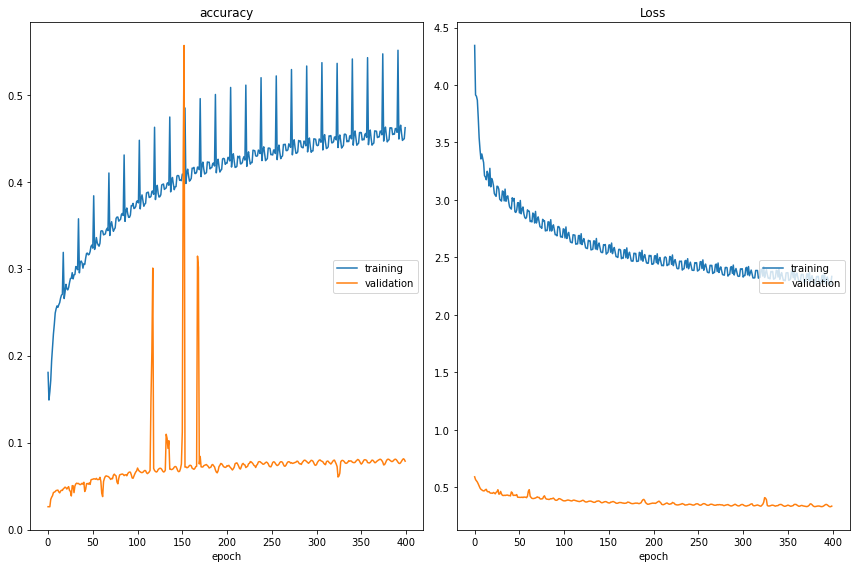

accuracy
	training         	 (min:    0.149, max:    0.551, cur:    0.462)
	validation       	 (min:    0.026, max:    0.557, cur:    0.079)
Loss
	training         	 (min:    2.266, max:    4.344, cur:    2.334)
	validation       	 (min:    0.330, max:    0.591, cur:    0.336)


In [ ]:
from livelossplot import PlotLossesKeras

BATCH_SIZE = 512

one_layer_model.fit(
    get_batch_generator(sentences, batch_size=BATCH_SIZE),
    y=None,
    steps_per_epoch=int(len(sentences_train) / BATCH_SIZE),
    epochs=400, verbose=False, validation_data=(X_test, y_test),
    callbacks=[one_layer_nn_char_sampler, one_layer_nn_checkpoint,
               one_layer_nn_conditional_checkpoint, PlotLossesKeras()]
)

Итак, когда все обучилось, можем посмотреть на динамику ошибок, точности и на сами порожденные тексты на разных эпохах и при разных температурах.

### Многослойная LSTM-сеть

In [ ]:
multi_layer_nn_files = {
    'out':'out/char_by_char_multi_layer.csv',
    'checkpoint':'checkpoint/char_by_char/multi_layer/best_accuracy.h5',
    'condition_checkpoint_pattern':'checkpoint/char_by_char/multi_layer/epoch_{}.h5'
}

Создадим и запустим трехслойную сеть, а в конце слоев LSTM поставим Dropout. Кроме того, с помощью функции concatenate укажем сети, что мы создаем магистрали: на вход каждому новому рекуррентному слою мы подаем дополнительно и то, что подавалось на вход предыдущим, а TimeDistributed слою — выходы всех LSTM-слоев.

In [ ]:
from keras import Model
from keras.layers import Input, concatenate, LSTM, Dropout, TimeDistributed, Dense, Activation
from keras.optimizers import Adam

vec = Input(shape=(None, vec_space_dim))
l1 = LSTM(units=128, activation='tanh', return_sequences=True)(vec)
l1_d = Dropout(0.2)(l1)

input_2 = concatenate([vec, l1_d])
l2 = LSTM(units=128, activation='tanh', return_sequences=True)(input_2)
l2_d = Dropout(0.2)(l2)

input_3 = concatenate([vec, l2_d])
l3 = LSTM(units=128, activation='tanh', return_sequences=True)(input_3)
l3_d = Dropout(0.2)(l3)

input_d = concatenate([l1_d, l2_d, l3_d])
dense_3 = TimeDistributed(Dense(units=vec_space_dim))(input_d)
output_res = Activation('softmax')(dense_3)

multi_layer_model = Model(inputs=vec, outputs=output_res)

# multi_layer_model.load_weights(multi_layer_nn_checkpoint_filename)

multi_layer_model.compile(loss='categorical_crossentropy', optimizer=Adam(clipnorm=1), metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

multi_layer_nn_sampler = CharSampler(multi_layer_model, multi_layer_nn_files['out'])
multi_layer_nn_conditional_checkpoint = ConditionalCheckpoint(
    model=one_layer_model,
    filename=multi_layer_nn_files['condition_checkpoint_pattern'],
    epoch_weights_checkpoint=[1, 50, 100, 250, 400, 600]
)
multi_layer_nn_checkpoint = ModelCheckpoint(
    filepath=multi_layer_nn_files['checkpoint'],
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

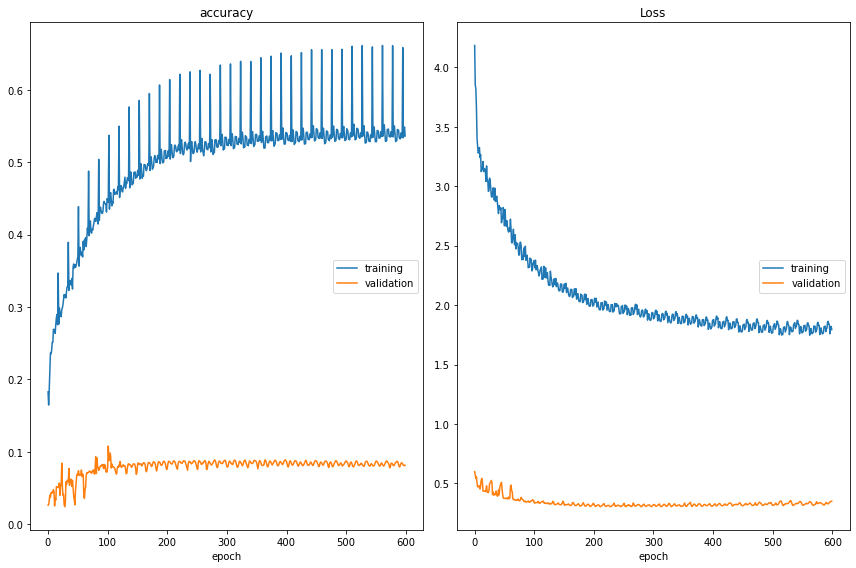

accuracy
	training         	 (min:    0.165, max:    0.661, cur:    0.536)
	validation       	 (min:    0.024, max:    0.108, cur:    0.081)
Loss
	training         	 (min:    1.747, max:    4.183, cur:    1.795)
	validation       	 (min:    0.305, max:    0.600, cur:    0.351)


In [ ]:
BATCH_SIZE = 512

multi_layer_model.fit(
    get_batch_generator(sentences, batch_size=BATCH_SIZE),
    y=None,
    steps_per_epoch=int(len(sentences_train) / BATCH_SIZE),
    epochs=600, verbose=False, validation_data=(X_test, y_test),
    callbacks=[multi_layer_nn_sampler, multi_layer_nn_checkpoint,
               multi_layer_nn_conditional_checkpoint, PlotLossesKeras()]
)